In [1]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Flatten, Dense
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

from utils import LossHistory, plotHistory

Using TensorFlow backend.


# Args

In [2]:
num_class = 10
input_shape = (28, 28, 1)

# Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255

y_train = to_categorical(y_train, num_class)
y_test = to_categorical(y_test, num_class)

# Model

In [5]:
model = Sequential([
    Convolution2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_class, activation='softmax')
])

# Training

In [6]:
model.compile(loss=categorical_crossentropy, optimizer=Adadelta(), metrics=['accuracy'])

In [7]:
history = LossHistory()
hist = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=2,
                    validation_data=(x_test, y_test),
                    callbacks=[history])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 42s 698us/step - loss: 0.1594 - acc: 0.9511 - val_loss: 0.0574 - val_acc: 0.9815
Epoch 2/2
60000/60000 [==============================] - 43s 721us/step - loss: 0.0530 - acc: 0.9844 - val_loss: 0.0446 - val_acc: 0.9842


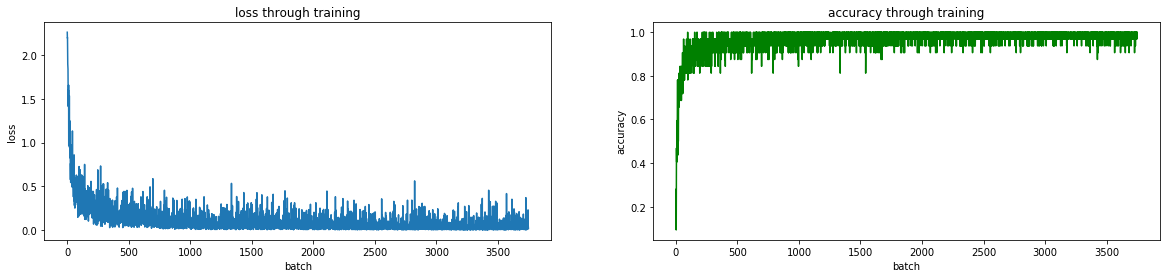

In [8]:
plotHistory(history.loss, history.acc)